## Ploting results from feature compression datasets

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle

In [3]:
files = set()
for f in os.listdir('results/lassoCV_DMS/esm2_150M_all/'):
    name = f.split('_esm2_150M')[0]
    files.add(name)

len(files)

40

In [2]:
len(os.listdir('results/lassoCV_DMS/esm2_650M'))

40

## Results DMS

In [9]:
base_dir = 'results/lassoCV_DMS/esm2_150M_all'
results = pd.DataFrame()

for f in os.listdir(base_dir):
    parts = f.split('_esm')
    dataset = parts[0]
    sub_parts = parts[1].replace('.csv', '')
    model = f"esm{sub_parts.split('_')[0]}_{sub_parts.split('_')[1]}"
    method = sub_parts.split('_')[2]
    
    file_path = os.path.join(base_dir, f)
    df = pd.read_csv(file_path, index_col=0)
    
    df['Dataset'] = dataset
    df['Model'] = model

    results = pd.concat([results, df])

results

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset
0,esm2_150M,1,0.112793,1.691488,1.996405,0.102670,1.656042,1.965677,0.290026,0.285563,24,rbf1,BF520_env_Bloom2018
1,esm2_150M,2,0.152526,1.645394,1.947709,0.134648,1.636403,1.944731,0.388256,0.336181,46,rbf1,BF520_env_Bloom2018
2,esm2_150M,3,0.102220,1.690724,1.997223,0.108833,1.697843,2.002759,0.279350,0.274983,18,rbf1,BF520_env_Bloom2018
3,esm2_150M,4,0.112482,1.686306,1.988794,0.090167,1.692772,2.012003,0.282585,0.272652,21,rbf1,BF520_env_Bloom2018
4,esm2_150M,5,0.098993,1.684092,1.992737,0.110092,1.740808,2.033340,0.272459,0.297204,17,rbf1,BF520_env_Bloom2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,esm2_150M,1,0.747560,0.152884,0.196845,0.738953,0.154087,0.199617,0.888834,0.883850,554,pca2,PABP_YEAST_Fields2013_doubles
1,esm2_150M,2,0.748257,0.152071,0.196224,0.735414,0.156469,0.202334,0.889467,0.879490,550,pca2,PABP_YEAST_Fields2013_doubles
2,esm2_150M,3,0.747757,0.152400,0.196188,0.736438,0.156020,0.202918,0.888274,0.886296,557,pca2,PABP_YEAST_Fields2013_doubles
3,esm2_150M,4,0.749375,0.151785,0.196373,0.732014,0.156901,0.201239,0.888940,0.882778,554,pca2,PABP_YEAST_Fields2013_doubles


In [10]:
#results.to_csv('results/summary_DMS_all_LassoCV_esm2_150M_all_methods.csv')

## Results DMS

In [8]:
old_names = ['HG_FLU_Bloom2016', 'BLAT_ECOLX_Ostermeier2014',
       'RL401_YEAST_Bolon2014', 'PABP_YEAST_Fields2013_doubles',
       'B3VI55_LIPST_Whitehead2015', 'TIM_THETH', 'CALM1_HUMAN_Roth2017',
       'parEparD_Laub2015_all', 'BF520_env_Bloom2018',
       'UBC9_HUMAN_Roth2017', 'DLG4_RAT_Ranganathan2012',
       'BRCA1_HUMAN_RING', 'TPMT_HUMAN_Fowler2018',
       'MTH3_HAEAESTABILIZED_Tawfik2015', 'HSP82_YEAST_Bolon2016',
       'MK01_HUMAN_Johannessen', 'PTEN_HUMAN_Fowler2018',
       'BG505_env_Bloom2018', 'BLAT_ECOLX_Tenaillon2013', 'TIM_SULSO',
       'B3VI55_LIPSTSTABLE', 'RL401_YEAST_Bolon2013',
       'PABP_YEAST_Fields2013_singles', 'BLAT_ECOLX_Ranganathan2015',
       'RL401_YEAST_Fraser2016', 'TIM_THEMA', 'AMIE_PSEAE_Whitehead',
       'BG_STRSQ_hmmerbit', 'GAL4_YEAST_Shendure2015',
       'BLAT_ECOLX_Palzkill2012', 'SUMO1_HUMAN_Roth2017',
       'RASH_HUMAN_Kuriyan', 'YAP1_HUMAN_Fields2012_singles',
       'KKA2_KLEPN_Mikkelsen2014', 'TPK1_HUMAN_Roth2017',
       'PA_FLU_Sun2015', 'IF1_ECOLI']

new_names = ['HG FLU', 'BLAT ECOLX 2014', 'RL401 2014',
       'PABP doubles', 'B3VI55 LIPST',
       'TIM THETH', 'CALM1 HUMAN', 'parEparD all',
       'BF520 env', 'UBC9 HUMAN', 'DLG4 RAT',
       'BRCA1 RING', 'TPMT HUMAN',
       'MTH3 HAEAESTABILIZED', 'HSP82 YEAST',
       'MK01 HUMAN', 'PTEN HUMAN',
       'BG505 env', 'BLAT ECOLX 2013', 'TIM SULSO',
       'B3VI55 LIPSTSTABLE', 'RL401 2013',
       'PABP singles', 'BLAT ECOLX 2015',
       'RL401 2016', 'TIM THEMA', 'AMIE PSEAE',
       'BG STRSQ', 'GAL4 YEAST',
       'BLAT ECOLX 2012', 'SUMO1 HUMAN',
       'RASH HUMAN', 'YAP1 singles',
       'KKA2 KLEPN', 'TPK1 HUMAN',
       'PA FLU', 'IF1 ECOLI']

name_map = dict(zip(old_names, new_names))
name_map

{'HG_FLU_Bloom2016': 'HG FLU',
 'BLAT_ECOLX_Ostermeier2014': 'BLAT ECOLX 2014',
 'RL401_YEAST_Bolon2014': 'RL401 2014',
 'PABP_YEAST_Fields2013_doubles': 'PABP doubles',
 'B3VI55_LIPST_Whitehead2015': 'B3VI55 LIPST',
 'TIM_THETH': 'TIM THETH',
 'CALM1_HUMAN_Roth2017': 'CALM1 HUMAN',
 'parEparD_Laub2015_all': 'parEparD all',
 'BF520_env_Bloom2018': 'BF520 env',
 'UBC9_HUMAN_Roth2017': 'UBC9 HUMAN',
 'DLG4_RAT_Ranganathan2012': 'DLG4 RAT',
 'BRCA1_HUMAN_RING': 'BRCA1 RING',
 'TPMT_HUMAN_Fowler2018': 'TPMT HUMAN',
 'MTH3_HAEAESTABILIZED_Tawfik2015': 'MTH3 HAEAESTABILIZED',
 'HSP82_YEAST_Bolon2016': 'HSP82 YEAST',
 'MK01_HUMAN_Johannessen': 'MK01 HUMAN',
 'PTEN_HUMAN_Fowler2018': 'PTEN HUMAN',
 'BG505_env_Bloom2018': 'BG505 env',
 'BLAT_ECOLX_Tenaillon2013': 'BLAT ECOLX 2013',
 'TIM_SULSO': 'TIM SULSO',
 'B3VI55_LIPSTSTABLE': 'B3VI55 LIPSTSTABLE',
 'RL401_YEAST_Bolon2013': 'RL401 2013',
 'PABP_YEAST_Fields2013_singles': 'PABP singles',
 'BLAT_ECOLX_Ranganathan2015': 'BLAT ECOLX 2015',
 'RL

In [23]:
dta_longer_1022 = [
    'BRCA1_HUMAN_RING', 'UBE4B_MOUSE_Klevit2013_singles',
    'BRCA1_HUMAN_BRCT', 'POLG_HCVJF_Sun2014', 'BG505_env_Bloom2018'] 

In [16]:
data = pd.read_csv('results/summary_DMS_all_LassoCV_esm2_150M_all_methods.csv', index_col=0)
data['Dataset'] = data['Dataset'].replace(name_map)
data = data.query("Compression_method == 'mean'").copy()
data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset
0,esm2_150M,1,0.589056,0.313062,0.384125,0.563713,0.338379,0.415842,0.768998,0.761475,85,mean,TIM THETH
1,esm2_150M,2,0.629980,0.298107,0.369637,0.525800,0.329026,0.411745,0.791999,0.717081,103,mean,TIM THETH
2,esm2_150M,3,0.634605,0.298845,0.369264,0.452626,0.344631,0.431981,0.795808,0.636300,90,mean,TIM THETH
3,esm2_150M,4,0.618163,0.304358,0.376434,0.551064,0.322041,0.397815,0.784933,0.752485,105,mean,TIM THETH
4,esm2_150M,5,0.626037,0.296734,0.369013,0.553658,0.338896,0.411953,0.782906,0.762965,103,mean,TIM THETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,esm2_150M,1,0.505824,0.470148,0.625752,0.429799,0.494200,0.639906,0.673560,0.642439,212,mean,BG STRSQ
1,esm2_150M,2,0.475651,0.480325,0.639652,0.381731,0.516161,0.688509,0.667450,0.571913,149,mean,BG STRSQ
2,esm2_150M,3,0.456392,0.491596,0.652955,0.430379,0.494538,0.651793,0.664287,0.602986,146,mean,BG STRSQ
3,esm2_150M,4,0.488949,0.459300,0.613258,0.390577,0.542847,0.750187,0.661272,0.669481,179,mean,BG STRSQ


In [17]:
cols = ['Dataset', 'R2_score_test', 'rho_score_test']
dataset_order = data[cols].groupby('Dataset').mean().sort_values('R2_score_test', ascending=False).index
data['Dataset'] = pd.Categorical(data['Dataset'], categories=dataset_order, ordered=True)
data.sort_values('Dataset', inplace=True)
data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset
4,esm2_150M,5,0.758130,0.150031,0.192816,0.749241,0.152444,0.195076,0.899111,0.892414,471,mean,PABP doubles
3,esm2_150M,4,0.758308,0.149768,0.192841,0.748281,0.153501,0.195036,0.898028,0.898834,483,mean,PABP doubles
0,esm2_150M,1,0.758891,0.149933,0.192376,0.745393,0.152281,0.197139,0.899615,0.892320,475,mean,PABP doubles
2,esm2_150M,3,0.756899,0.150443,0.192600,0.753208,0.150812,0.196356,0.898668,0.899595,469,mean,PABP doubles
1,esm2_150M,2,0.758003,0.149781,0.192388,0.749449,0.153128,0.196894,0.899582,0.892236,468,mean,PABP doubles
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,esm2_150M,4,0.044864,0.372232,0.492598,0.030363,0.396396,0.588804,0.297564,0.276792,12,mean,PA FLU
2,esm2_150M,3,0.040456,0.378217,0.525126,0.051210,0.369149,0.461249,0.290340,0.305439,14,mean,PA FLU
1,esm2_150M,2,0.036775,0.382848,0.527936,0.018739,0.368113,0.458377,0.273875,0.222044,6,mean,PA FLU
0,esm2_150M,1,0.033754,0.378521,0.519465,0.039416,0.380228,0.496585,0.260931,0.263654,6,mean,PA FLU


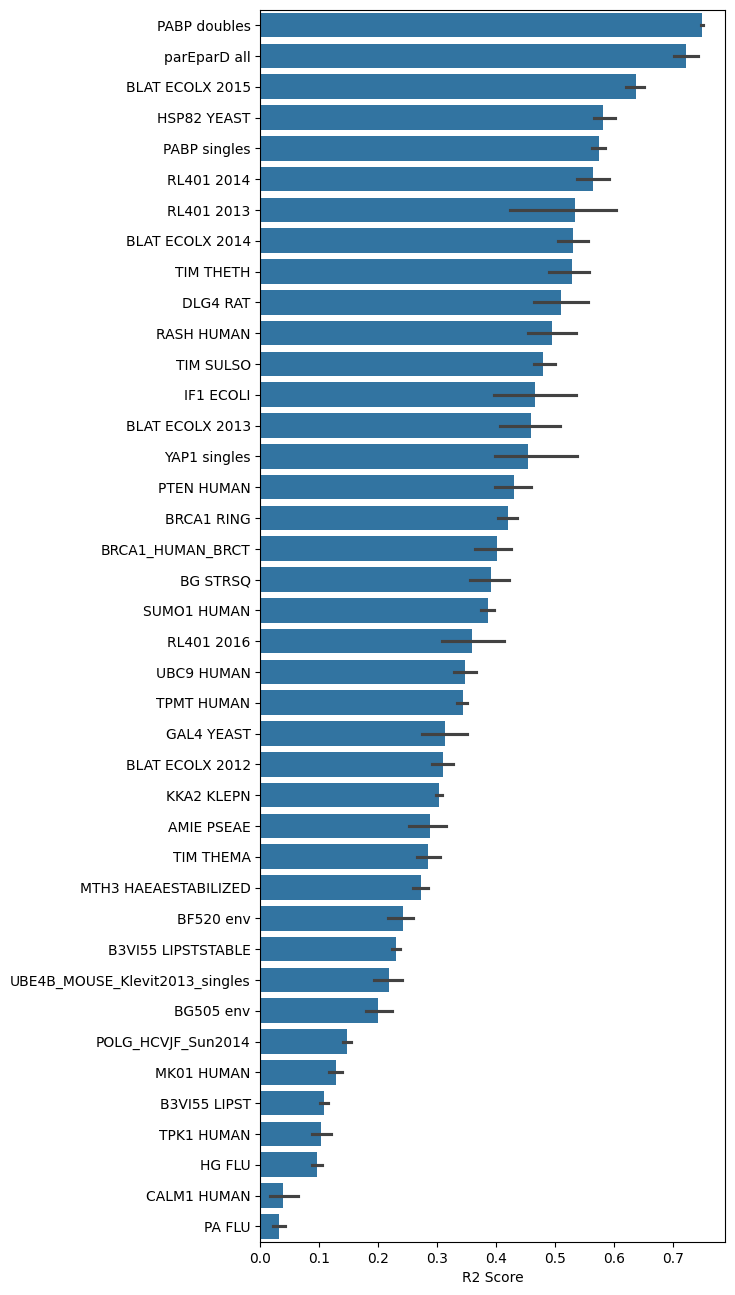

In [19]:
plt.figure(figsize=(6, 16))
sns.barplot(data=data, y='Dataset', x='R2_score_test')
plt.ylabel('R2_score_test')
plt.ylabel('')
plt.xlabel('R2 Score')
#plt.savefig('results/summary_DMS_all_LassoCV_esm2_150M_all_methods.png', dpi=600, bbox_inches='tight')
plt.show()

# Multi Model Results on DMS9 dataset

In [3]:
cols_order = [
    'Dataset', 'Compression_method', 'Model', 'Fold', 'nun_zero_coefs', 
    'R2_score_train', 'MAE_score_train', 'RMSE_score_train', 'rho_score_train', 
    'R2_score_test', 'MAE_score_test', 'RMSE_score_test', 'rho_score_test',
    ]

In [5]:
os.listdir('results/lassoCV_DMS')

['esm2_35M',
 'esm2_650M',
 'esm1v_650M',
 'esm2_15B',
 'esm2_8M',
 'esm2_150M_old_miss_long_seqs',
 'summary_DMS_all_LassoCV_esm2_150M.csv',
 'esm2_3B',
 'esm2_150M_all']

In [20]:
import re

df = pd.DataFrame()

models = ['esm1v_650M', 'esm2_8M', 'esm2_35M', 'esm2_150M_all', 'esm2_650M', 'esm2_3B', 'esm2_15B']
for model in models:
    for file in os.listdir(f'results/lassoCV_DMS/{model}'):
        if file.endswith('.csv'):
            target = re.split(r'_esm.*_', file)[0]
            #model = file.split('_esm2_')[1].split('_')[0]
            data = pd.read_csv(f'results/lassoCV_DMS/{model}/{file}', index_col=0)
            data['Model'] = model
            data['Dataset'] = target
            df = pd.concat([df, data])

df= df[cols_order].copy() 
df

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test
0,DLG4_RAT_Ranganathan2012,mean,esm1v_650M,1,107,0.606299,0.167978,0.247419,0.678617,0.517306,0.197666,0.286360,0.612190
1,DLG4_RAT_Ranganathan2012,mean,esm1v_650M,2,142,0.654392,0.157994,0.230258,0.701371,0.586409,0.184295,0.271060,0.668717
2,DLG4_RAT_Ranganathan2012,mean,esm1v_650M,3,66,0.493072,0.196938,0.287347,0.622593,0.445058,0.201264,0.278198,0.532599
3,DLG4_RAT_Ranganathan2012,mean,esm1v_650M,4,75,0.532985,0.183546,0.267771,0.616574,0.430552,0.207193,0.317653,0.611573
4,DLG4_RAT_Ranganathan2012,mean,esm1v_650M,5,106,0.619924,0.174690,0.251558,0.684431,0.514205,0.166521,0.246327,0.655471
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,GAL4_YEAST_Shendure2015,mean,esm2_15B,1,50,0.405399,3.438468,4.061600,0.718511,0.316305,3.682564,4.432493,0.636308
1,GAL4_YEAST_Shendure2015,mean,esm2_15B,2,102,0.520333,3.016991,3.669269,0.771544,0.466474,3.198986,3.834737,0.736154
2,GAL4_YEAST_Shendure2015,mean,esm2_15B,3,36,0.347786,3.654293,4.283622,0.689833,0.268484,3.826350,4.482737,0.596558
3,GAL4_YEAST_Shendure2015,mean,esm2_15B,4,36,0.325067,3.703526,4.340026,0.678860,0.283312,3.846994,4.510645,0.634199


In [21]:
df['Dataset'] = df['Dataset'].replace(name_map)
df

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test
0,DLG4 RAT,mean,esm1v_650M,1,107,0.606299,0.167978,0.247419,0.678617,0.517306,0.197666,0.286360,0.612190
1,DLG4 RAT,mean,esm1v_650M,2,142,0.654392,0.157994,0.230258,0.701371,0.586409,0.184295,0.271060,0.668717
2,DLG4 RAT,mean,esm1v_650M,3,66,0.493072,0.196938,0.287347,0.622593,0.445058,0.201264,0.278198,0.532599
3,DLG4 RAT,mean,esm1v_650M,4,75,0.532985,0.183546,0.267771,0.616574,0.430552,0.207193,0.317653,0.611573
4,DLG4 RAT,mean,esm1v_650M,5,106,0.619924,0.174690,0.251558,0.684431,0.514205,0.166521,0.246327,0.655471
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,GAL4 YEAST,mean,esm2_15B,1,50,0.405399,3.438468,4.061600,0.718511,0.316305,3.682564,4.432493,0.636308
1,GAL4 YEAST,mean,esm2_15B,2,102,0.520333,3.016991,3.669269,0.771544,0.466474,3.198986,3.834737,0.736154
2,GAL4 YEAST,mean,esm2_15B,3,36,0.347786,3.654293,4.283622,0.689833,0.268484,3.826350,4.482737,0.596558
3,GAL4 YEAST,mean,esm2_15B,4,36,0.325067,3.703526,4.340026,0.678860,0.283312,3.846994,4.510645,0.634199


In [13]:
#df.to_csv('results/summary_lassoCV_multi_model_DMS9.csv')

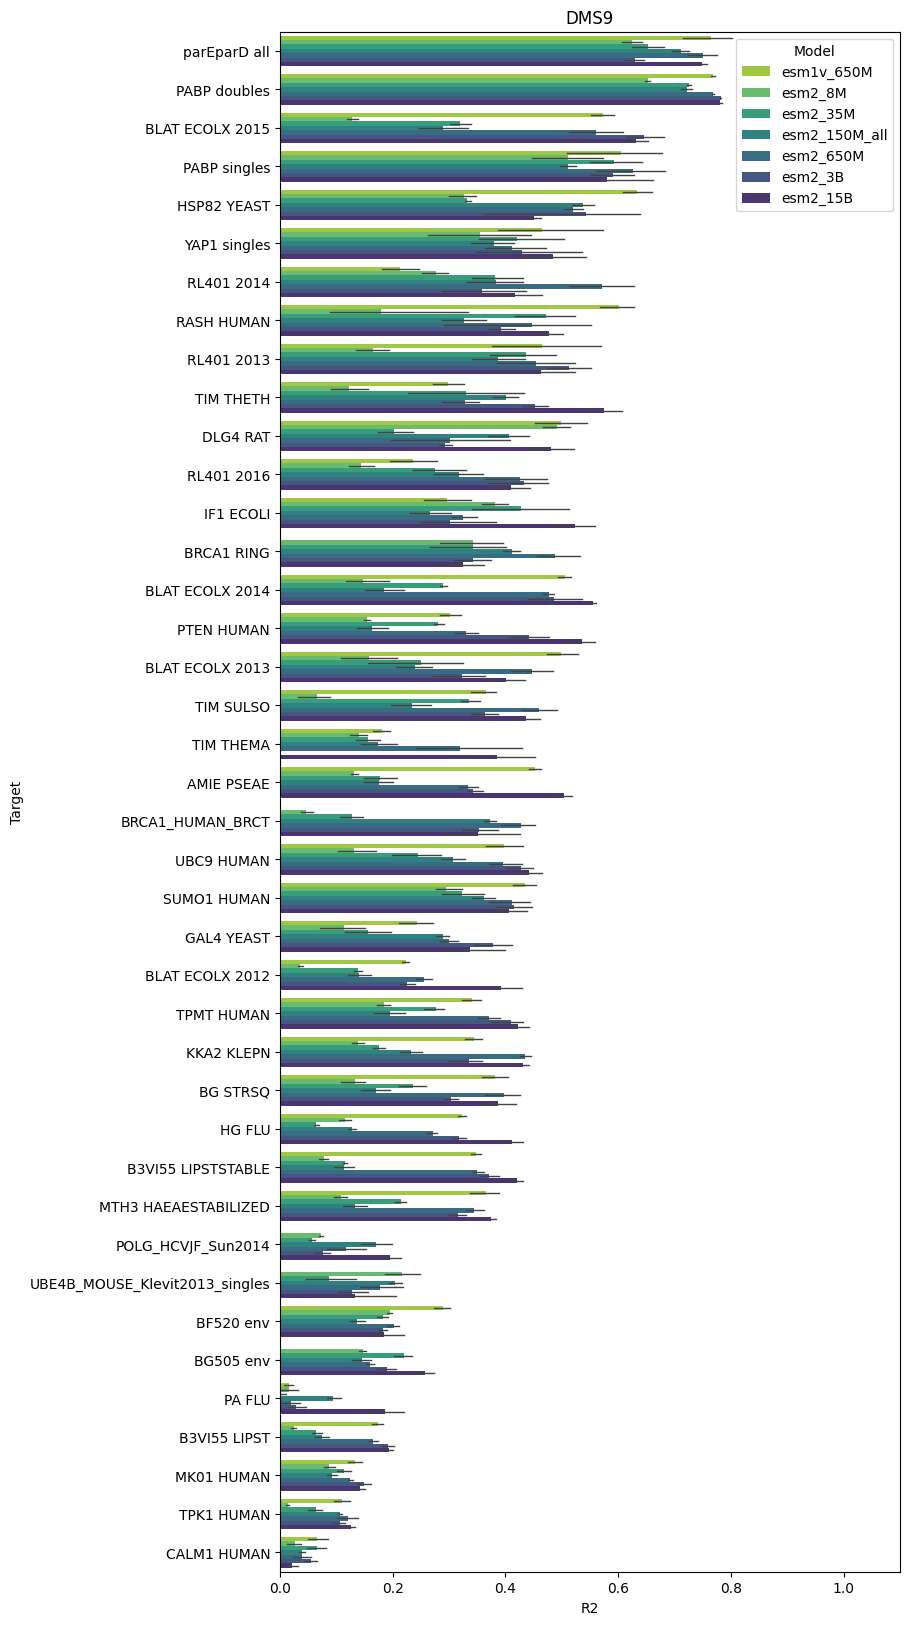

In [24]:
# Datasets order
mean_scores = df.groupby('Dataset')['R2_score_test'].max().sort_values(ascending=False)
sorted_datasets = mean_scores.index
model_order = ['esm1v_650M', 'esm2_8M', 'esm2_35M', 'esm2_150M_all', 'esm2_650M', 'esm2_3B', 'esm2_15B']

# plot
plt.figure(figsize=(8, 20))
plt.title('DMS9')
sns.barplot(
    data=df, x='R2_score_test', y='Dataset', hue='Model', order=sorted_datasets, 
    hue_order=model_order, palette='viridis_r', err_kws={'linewidth': 1})
plt.xlabel('R2')
plt.xlim(0, 1.1)
plt.ylabel('Target')

#plt.savefig('results/summary_lassoCV_multi_model_DMS9.png', dpi=600, bbox_inches='tight')
plt.show()

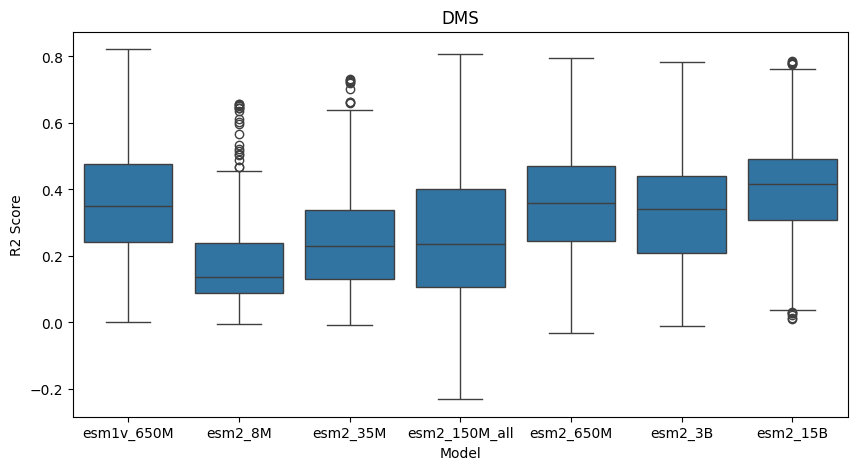

In [28]:
plt.figure(figsize=(10, 5))
plt.title('DMS')
sns.boxplot(data=df, x='Model', y='R2_score_test', order=model_order)
plt.ylabel('R2 Score')
#plt.ylim(0, 1)
plt.show()

# Multi Model Results on Pisces dataset

In [41]:
# model = 'esm2_8M'
# repl = 'layer_6_'
# os.makedirs(f"results/lassoCV_PISCES/{model}", exist_ok=True)

# for file in os.listdir('results/lassoCV_PISCES'):
#     if file.endswith('.csv'):
#         if model in file:
#             new_name = file.replace(repl, '')
#             os.rename(os.path.join('results/lassoCV_PISCES', file), os.path.join(f'results/lassoCV_PISCES/{model}', new_name))
        

In [49]:
import re

df = pd.DataFrame()
models = ['esm1v_650M', 'esm2_8M', 'esm2_35M', 'esm2_150M', 'esm2_650M', 'esm2_3B', 'esm2_15B']
for model in models:
    for file in os.listdir(f'results/lassoCV_PISCES/{model}'):
        if file.endswith('.csv'):
            target = re.split(r'_esm.*_', file)[0]
            data = pd.read_csv(f'results/lassoCV_PISCES/{model}/{file}', index_col=0)
            data['Model'] = model
            data['Dataset'] = target
            df = pd.concat([df, data])

df= df[cols_order].copy() 
df

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test
0,SS_H,mean,esm1v_650M,1,938,0.927262,0.037465,0.052801,0.956012,0.919686,0.038999,0.054764,0.950769
1,SS_H,mean,esm1v_650M,2,949,0.927665,0.037322,0.052617,0.956157,0.919050,0.039424,0.055136,0.950460
2,SS_H,mean,esm1v_650M,3,960,0.928309,0.037107,0.052094,0.956324,0.916120,0.040435,0.057369,0.951254
3,SS_H,mean,esm1v_650M,4,954,0.927198,0.037327,0.052812,0.956444,0.920738,0.039389,0.054443,0.948609
4,SS_H,mean,esm1v_650M,5,965,0.926950,0.037374,0.052609,0.955439,0.921982,0.039039,0.055232,0.954351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,PCP_length,mean,esm2_15B,1,3608,0.962813,20.400271,28.441053,0.980757,0.943147,25.076990,34.961800,0.968424
1,PCP_length,mean,esm2_15B,2,3521,0.963034,20.546726,28.538302,0.980580,0.940033,25.383983,34.942666,0.969075
2,PCP_length,mean,esm2_15B,3,3450,0.962348,20.484766,28.617726,0.980522,0.940994,25.714836,35.616464,0.969258
3,PCP_length,mean,esm2_15B,4,3591,0.962977,20.340407,28.288456,0.980480,0.941190,25.767728,35.997227,0.969588


In [20]:
#df.to_csv('results/summary_lassoCV_multi_model_pisces.csv')

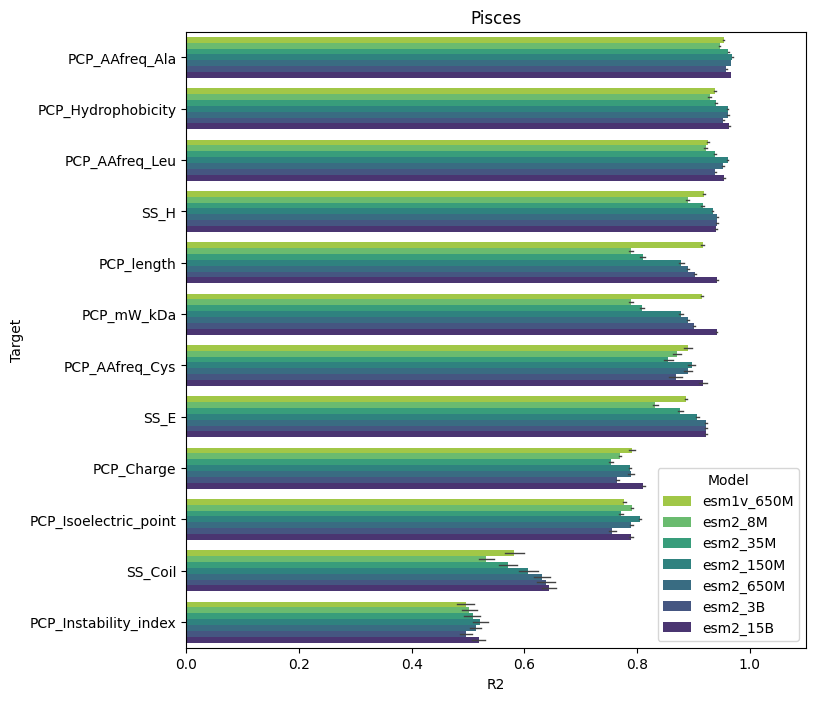

In [51]:
# Datasets order
mean_scores = df.groupby('Dataset')['R2_score_test'].max().sort_values(ascending=False)
sorted_datasets = mean_scores.index
model_order = ['esm1v_650M', 'esm2_8M', 'esm2_35M', 'esm2_150M', 'esm2_650M', 'esm2_3B', 'esm2_15B']
# plot
plt.figure(figsize=(8, 8))
plt.title('Pisces')
sns.barplot(
    data=df, x='R2_score_test', y='Dataset', hue='Model', order=sorted_datasets, 
    hue_order=model_order, palette='viridis_r', err_kws={'linewidth': 1})
plt.xlabel('R2')
plt.xlim(0, 1.1)
plt.ylabel('Target')

#plt.savefig('results/summary_results/summary_lassoCV_multi_model_pisces.png', dpi=600, bbox_inches='tight')
plt.show()

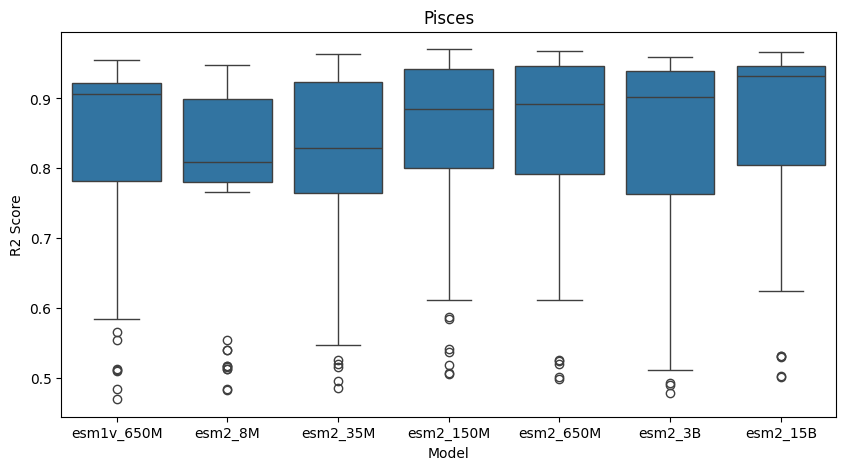

In [54]:
plt.figure(figsize=(10, 5))
plt.title('Pisces')
sns.boxplot(data=df, x='Model', y='R2_score_test', order=model_order)
plt.ylabel('R2 Score')
#plt.ylim(0, 1)
plt.show()

## Zero shot predictiond from proteinGym

In [8]:
data = pd.read_csv('results/DMS_zero_shot_ESMs.csv')
data

,DMS ID,ESM-1b,ESM-1v (single),ESM-1v (ensemble),ESM2 (8M),ESM2 (35M),ESM2 (150M),ESM2 (650M),ESM2 (3B),ESM2 (15B)
0,A0A140D2T1_ZIKV_Sourisseau_2019,-0.001,-0.048,0.015,-0.073,-0.054,-0.058,0.213,0.363,0.375
1,A0A192B1T2_9HIV1_Haddox_2018,0.456,0.492,0.516,-0.003,0.015,0.035,0.080,0.132,0.164
2,A0A1I9GEU1_NEIME_Kennouche_2019,0.040,0.068,0.068,-0.037,-0.047,-0.016,0.030,0.027,0.025
3,A0A247D711_LISMN_Stadelmann_2021,0.087,0.088,0.093,0.064,0.084,0.097,0.066,0.084,0.084
4,A0A2Z5U3Z0_9INFA_Doud_2016,0.124,0.516,0.550,-0.004,0.013,0.064,0.507,0.498,0.501
...,...,...,...,...,...,...,...,...,...,...
212,VKOR1_HUMAN_Chiasson_2020_activity,0.419,0.427,0.448,0.016,0.298,0.369,0.430,0.446,0.445
213,VRPI_BPT7_Tsuboyama_2023_2WNM,0.498,0.368,0.374,0.252,0.410,0.507,0.587,0.612,0.468
214,YAIA_ECOLI_Tsuboyama_2023_2KVT,0.593,0.270,0.481,-0.107,0.173,0.572,0.625,0.684,0.684
215,YAP1_HUMAN_Araya_2012,0.333,0.280,0.285,0.411,0.457,0.451,0.466,0.382,0.313


In [13]:
data = pd.read_csv('results/DMS_zero_shot_ESMs.csv')

val_vars = data.columns.values

data_melted = data.melt(id_vars=['DMS ID'], value_vars=val_vars, var_name='Model', value_name='Rho')
data_melted

,DMS ID,Model,Rho
0,A0A140D2T1_ZIKV_Sourisseau_2019,ESM-1b,-0.001
1,A0A192B1T2_9HIV1_Haddox_2018,ESM-1b,0.456
2,A0A1I9GEU1_NEIME_Kennouche_2019,ESM-1b,0.040
3,A0A247D711_LISMN_Stadelmann_2021,ESM-1b,0.087
4,A0A2Z5U3Z0_9INFA_Doud_2016,ESM-1b,0.124
...,...,...,...
1948,VKOR1_HUMAN_Chiasson_2020_activity,ESM2 (15B),0.445
1949,VRPI_BPT7_Tsuboyama_2023_2WNM,ESM2 (15B),0.468
1950,YAIA_ECOLI_Tsuboyama_2023_2KVT,ESM2 (15B),0.684
1951,YAP1_HUMAN_Araya_2012,ESM2 (15B),0.313


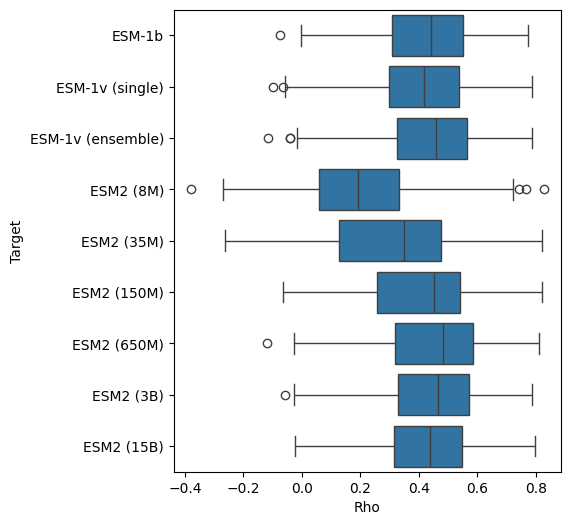

In [14]:
# Plot the boxplot with sorted Model
plt.figure(figsize=(5, 6))
sns.boxplot(data=data_melted, x='Rho', y='Model')
plt.xlabel('Rho')
#plt.xlim(0, 1.1)
plt.ylabel('Target')
plt.show()

# Sample size effect on predictions

## DMS HIS7

In [2]:
data = pd.DataFrame()
for model in ['150M', '650M', '15B']:
    dta = pd.read_csv(f'results/lassoCV_HIS7/HIS7_YEAST_Kondrashov2017_sampling_esm2_{model}_mean.csv', index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    data = pd.concat([data, dta], axis=0)

data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size
0,150M,1,0.619895,0.228129,0.263205,-0.601619,0.469460,0.587375,0.784650,0.078811,9,32
1,150M,2,0.000000,0.430087,0.449912,-0.045965,0.418240,0.437628,NaN,NaN,0,32
2,150M,3,0.000000,0.430749,0.452345,-0.000844,0.383574,0.421980,NaN,NaN,0,32
3,150M,4,0.000000,0.427461,0.444831,-0.204463,0.448542,0.462672,NaN,NaN,0,32
4,150M,5,0.999899,0.003331,0.004561,-4.403216,0.808285,0.963538,0.977876,-0.724714,556,32
...,...,...,...,...,...,...,...,...,...,...,...,...
0,15B,1,0.785086,0.155596,0.208231,0.784361,0.155505,0.208202,0.829845,0.827319,1060,496137
1,15B,2,0.785620,0.155481,0.207997,0.782953,0.155795,0.208778,0.829999,0.827626,1024,496137
2,15B,3,0.785580,0.155334,0.207854,0.782883,0.156590,0.209468,0.828984,0.831124,1026,496137
3,15B,4,0.785269,0.155381,0.207996,0.785261,0.155786,0.208356,0.829419,0.829770,1042,496137


In [39]:
#data.to_csv('results/summary_lassoCV_HIS7_datasize_effect.csv')

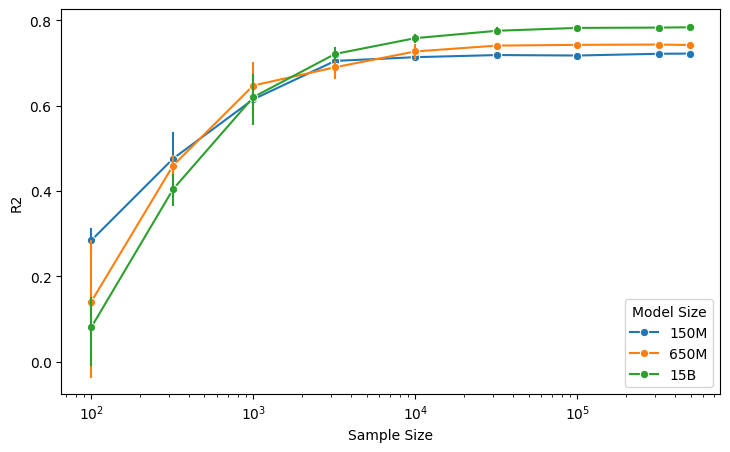

In [4]:
#plotting the results
data = data.query('Sample_size >=100')
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='Model', marker='o', err_style="bars", palette='viridis_r')
plt.ylabel('R2')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
#plt.savefig('results/lassoCV_HIS7/HIS7_YEAST_Kondrashov2017_sampling_esm2_all_R2.png', dpi=600, bbox_inches='tight')
plt.show()

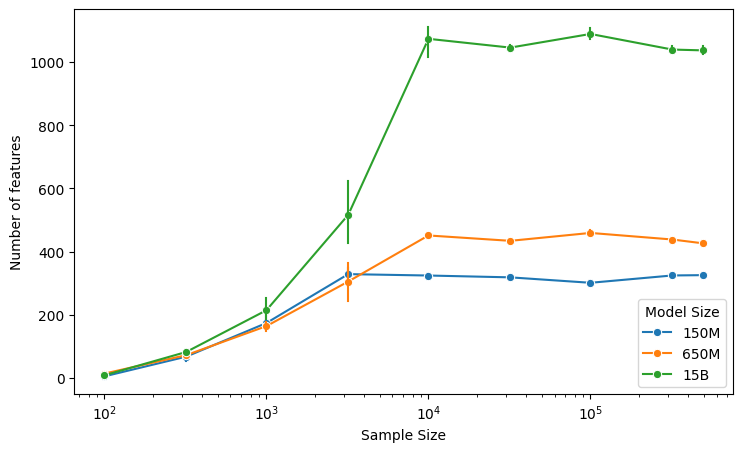

In [20]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='nun_zero_coefs', hue='Model', marker='o', err_style="bars", palette='viridis_r')
plt.ylabel('Number of features')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
plt.savefig('results/lassoCV_HIS7/HIS7_YEAST_Kondrashov2017_sampling_esm2_all_num_feature.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#data.to_csv('results/lassoCV_DMS/lassoCV_sampling/HIS7_YEAST_Kondrashov2017_sampling_esm2_all.csv')

# Sample size contribuition

In [7]:
dict_len = {}
dir = 'embeddings/DMS/'
for file in os.listdir(dir):
    if file.endswith('_esm2_150M'):
        file_name = file.split('_esm2_150M')[0]
        l = len(os.listdir(f'{dir}/{file}'))
        #dict_len[name_map[file_name]] = l
        dict_len[file_name] = l

df = pd.DataFrame.from_dict(dict_len, orient='index').sort_values(0, ascending=True).reset_index()
df.rename(columns={'index': 'Dataset', 0: 'length'}, inplace=True)
df

,Dataset,length
0,YAP1_HUMAN_Fields2012_singles,362
1,BRCA1_HUMAN_RING,660
2,UBE4B_MOUSE_Klevit2013_singles,899
3,BLAT_ECOLX_Tenaillon2013,989
4,PABP_YEAST_Fields2013_singles,1187
5,GAL4_YEAST_Shendure2015,1195
6,RL401_YEAST_Bolon2013,1269
7,RL401_YEAST_Fraser2016,1324
8,RL401_YEAST_Bolon2014,1435
9,IF1_ECOLI,1439


In [8]:
res = pd.read_csv(f'results/summary_lassoCV_multi_model_DMS9.csv', index_col=0)
res['dataset_size'] = res.apply(lambda row: dict_len[row['Dataset']], axis=1)
res

,Dataset,Compression_method,Model,Fold,nun_zero_coefs,R2_score_train,MAE_score_train,RMSE_score_train,rho_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_test,dataset_size
0,RL401_YEAST_Bolon2014,mean,150M,1,83,0.604357,0.185047,0.258908,0.722045,0.571506,0.184628,0.249809,0.730874,1435
1,RL401_YEAST_Bolon2014,mean,150M,2,190,0.775075,0.139150,0.194242,0.773434,0.608409,0.159835,0.243687,0.661513,1435
2,RL401_YEAST_Bolon2014,mean,150M,3,88,0.625654,0.177377,0.249001,0.729980,0.524448,0.204937,0.276760,0.689689,1435
3,RL401_YEAST_Bolon2014,mean,150M,4,85,0.611937,0.178466,0.248488,0.730821,0.535165,0.208633,0.294808,0.675884,1435
4,RL401_YEAST_Bolon2014,mean,150M,5,79,0.579664,0.187125,0.260591,0.714691,0.582016,0.200389,0.271566,0.741424,1435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,TIM_THETH,mean,650M,1,35,0.361872,0.407207,0.478669,0.615656,0.356228,0.433639,0.505136,0.608920,1519
1,TIM_THETH,mean,650M,2,30,0.374910,0.410856,0.480435,0.626150,0.343961,0.409030,0.484298,0.600788,1519
2,TIM_THETH,mean,650M,3,29,0.392636,0.403539,0.476080,0.645237,0.245562,0.430768,0.507148,0.445796,1519
3,TIM_THETH,mean,650M,4,29,0.349340,0.420637,0.491391,0.604669,0.353172,0.409031,0.477512,0.625267,1519


In [5]:
print(res.query("Model == '8M'")['R2_score_test'].corr(res.query("Model == '8M'")['dataset_size']))
print(res.query("Model == '150M'")['R2_score_test'].corr(res.query("Model == '150M'")['dataset_size']))
print(res.query("Model == '650M'")['R2_score_test'].corr(res.query("Model == '650M'")['dataset_size']))
print(res.query("Model == '15B'")['R2_score_test'].corr(res.query("Model == '15B'")['dataset_size']))


0.5600726679627362
0.6968601603273428
0.6000501096507697
0.7243736679233299


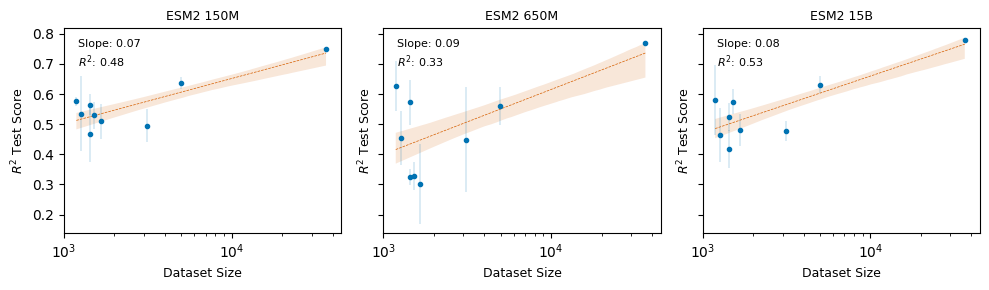

In [6]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for ax, ms in zip(axes, ['150M', '650M', '15B']):
    data = res.query(f"Model == '{ms}'")
    X = np.log(data['dataset_size'].values).reshape(-1, 1)  # Log-transform the x-values, and reshape so X is 2D
    y = data['R2_score_test'].values

    # Fit regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients
    slope = model.coef_[0]
    intercept = model.intercept_

    # Predict and calculate R²
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    
    ################ Annotation ################
    # Get mean and standard deviation for each dataset size
    grouped_data = data.groupby('dataset_size')['R2_score_test'].agg(['mean', 'std']).reset_index()
    # Add error bars
    ax.errorbar(grouped_data['dataset_size'], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=3, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)
    # Regression line
    sns.regplot(data=data, x='dataset_size', y='R2_score_test', scatter=False, logx=True, color='#D55E00', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    # Annotate
    ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.88, f'$R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.set_title(f'ESM2 {ms}', fontsize=9)
    ax.set_xlabel('Dataset Size', fontsize=9)
    ax.set_ylabel(r'$R^2$ Test Score', fontsize=9)
    ax.set_xlim(1000, 45000)
    ax.set_xscale('log')

plt.tight_layout()
#plt.savefig('results/lassoCV_DMS/summary_all_DMS_results_LassoCV_r2_sloop.png', dpi=600, bbox_inches='tight')
plt.show()

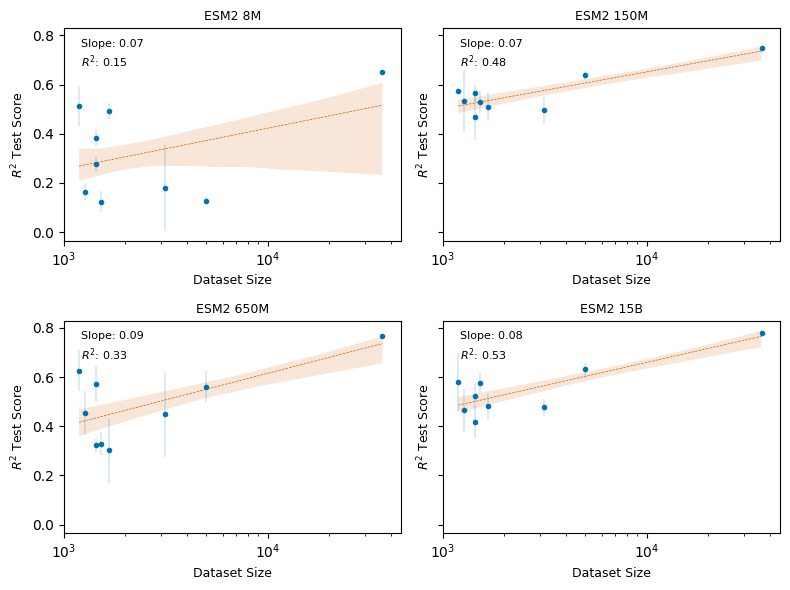

In [25]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=True)
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration

for ax, ms in zip(axes, ['8M', '150M', '650M', '15B']):
    data = res.query(f"Model == '{ms}'")

    X = np.log(data['dataset_size'].values).reshape(-1, 1)  # Log-transform the x-values, and reshape so X is 2D
    y = data['R2_score_test'].values

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients
    slope = model.coef_[0]
    intercept = model.intercept_

    # Predict and calculate R²
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    ################ Annotation ################
    # Get mean and standard deviation for each dataset size
    grouped_data = data.groupby('dataset_size')['R2_score_test'].agg(['mean', 'std']).reset_index()
    # Add error bars
    ax.errorbar(grouped_data['dataset_size'], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=3, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)
    # Regression line
    sns.regplot(data=data, x='dataset_size', y='R2_score_test', scatter=False, logx=True, color='#D55E00', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)

    # Annotate
    ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.88, f'$R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.set_title(f'ESM2 {ms}', fontsize=9)
    ax.set_xlabel('Dataset Size', fontsize=9)
    ax.set_ylabel(r'$R^2$ Test Score', fontsize=9)
    ax.set_xlim(1000, 45000)
    ax.set_xscale('log')

plt.tight_layout()
#plt.savefig('results/summary_results/summary_all_DMS_results_LassoCV_r2_sloop.png', dpi=600, bbox_inches='tight')
plt.show()